In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.swan import SWAN
from tricorder.procedure_codesets import cabg_names

from src.outcome_metrics import Metric, OxygenDelivery, CardiacPower, compute_o2_content, OxygenConsumption, pivot_tidy, melt_tidy

In [2]:
swan = SWAN('/Users/elijahc/data/compass/SWAN/')
eids = swan.procedures.sel(order_name=cabg_names).encounter_id.unique()

In [3]:
class Pulsatility(Metric):
    shortname = "Pulsatility"
    classname = 'Pulsatility'
    REQUIRES = {
        'flowsheet' : ['BP']
    }
    
    def __init__(self, db, encounter_id=None):
        super(Pulsatility,self).__init__(db, encounter_id)
    
    def after_flowsheet_sel(self,df):
        df = df[df.flowsheet_value.str.contains('/')]
        bp = [s.split('/') for s in df.flowsheet_value.values]
        bp = pd.DataFrame(bp,columns=['SBP','DBP'])
        df = df.drop(columns=['display_name','flowsheet_value'])
        df['display_name'] = 'SBP'
        df['flowsheet_value'] = bp.SBP
        dbp = df.copy()
        dbp.display_name = 'DBP'
        dbp.flowsheet_value = bp.DBP
        
        return pd.concat([df.reset_index(),dbp.reset_index()])
        
    def _prep(self, sample=None, encounter_id=None):
        if sample is not None and isinstance(sample, int):    
            components = self.db_sample(n=sample).dropna().sort_values(['encounter_id','time'])
        elif sample is not None and isinstance(sample, (list, type(np.array([])), type(pd.Series()))):
            components = self.db_fetch(encounter_id=sample)
        else:
            components = self.db_fetch()
        return pivot_tidy(components,t='time')
    
    def compute(self, sample=None, with_components=False, encounter_id=None):
        pvdf = self._prep(sample=sample, encounter_id=encounter_id)
        pvdf['pulsatility'] = pvdf.SBP-pvdf.DBP
        if not with_components:
            return pvdf['pulsatility'].reset_index()
        else:
            return pvdf

In [4]:
pc = swan.create_procedure_cohort(procedures=cabg_names)
pc.add_continuous_metric(Pulsatility)

CohortMetrics
- Pulsatility


[Pulsatility]

In [5]:
pc.add_continuous_metric(OxygenConsumption)
pc.add_continuous_metric(OxygenDelivery)
pc.add_continuous_metric(CardiacPower)

CohortMetrics
- Pulsatility
- OxygenConsumption
- OxygenDelivery
- CardiacPower


[Pulsatility, OxygenConsumption, OxygenDelivery, CardiacPower]

In [6]:
do = pc.metrics.OxygenDelivery.compute().query('name == "DO2_I"')
do.head()

  0%|          | 0/839 [00:00<?, ?it/s]

,encounter_id,time,name,value
13910,36802471722,26304 days 16:00:00,DO2_I,NaN
13911,36802471722,26304 days 18:00:00,DO2_I,NaN
13912,36802471722,26304 days 19:00:00,DO2_I,NaN
13913,36802471722,26304 days 20:00:00,DO2_I,575.880661
13914,36802471722,26304 days 21:00:00,DO2_I,437.762514


In [7]:
do = pc.align_metric(do)
do['hour'] = do.time/np.timedelta64(1,'D')*24
do = do.dropna().merge(pc.mortality, on='encounter_id', how='left')
do = do.query('hour >= -24 and hour <= 120')

In [8]:
do.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12737 entries, 0 to 14459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   encounter_id  12737 non-null  uint64         
 1   time          12737 non-null  timedelta64[ns]
 2   name          12737 non-null  object         
 3   value         12737 non-null  float64        
 4   offset        12737 non-null  int64          
 5   hour          12737 non-null  float64        
 6   death         12737 non-null  object         
dtypes: float64(2), int64(1), object(2), timedelta64[ns](1), uint64(1)
memory usage: 796.1+ KB


<AxesSubplot:xlabel='hour', ylabel='value'>

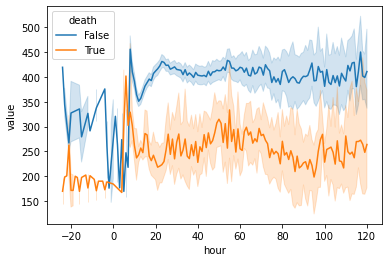

In [9]:
sns.lineplot(x='hour',y='value',hue='death',data=do.reset_index())

In [15]:
vo = pc.metrics.OxygenConsumption.compute().query('name == "VO2_I"')
vo = pc.align_metric(vo)
vo['hour'] = vo.time/np.timedelta64(1,'D')*24
vo = vo.dropna().merge(pc.mortality, on='encounter_id', how='left')
vo = vo.query('hour >= -24 and hour <= 120')

  0%|          | 0/840 [00:00<?, ?it/s]

<AxesSubplot:xlabel='hour', ylabel='value'>

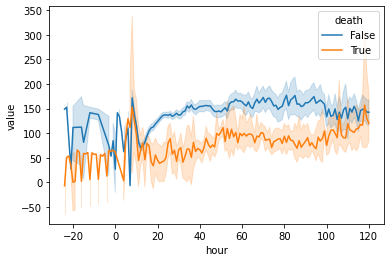

In [17]:
sns.lineplot(x='hour',y='value',hue='death',data=vo.reset_index())

In [21]:
cpo = pc.metrics.CardiacPower.compute()
cpo = pc.align_metric(cpo)
cpo['hour'] = cpo.time/np.timedelta64(1,'D')*24
cpo = cpo.dropna().merge(pc.mortality, on='encounter_id', how='left')
cpo

  0%|          | 0/840 [00:00<?, ?it/s]

,encounter_id,time,value,name,offset,hour,death
0,36802471722,0 days 20:00:00,1.490022,Cardiac Power,26304,20.00,False
1,36802471722,0 days 20:15:00,1.137472,Cardiac Power,26304,20.25,False
2,36802471722,0 days 20:30:00,0.899335,Cardiac Power,26304,20.50,False
3,36802471722,0 days 20:45:00,1.073171,Cardiac Power,26304,20.75,False
4,36802471722,0 days 21:00:00,0.799113,Cardiac Power,26304,21.00,False
...,...,...,...,...,...,...,...
38818,169906456092,1 days 03:00:00,0.603991,Cardiac Power,22740,27.00,False
38819,169906456092,1 days 04:00:00,0.629268,Cardiac Power,22740,28.00,False
38820,169906456092,1 days 05:00:00,0.654545,Cardiac Power,22740,29.00,False
38821,169906456092,1 days 06:00:00,0.679823,Cardiac Power,22740,30.00,False


In [44]:
cpo['time_d'] = pd.to_timedelta((cpo.hour/24).round(),unit='day')
cpo_pv = cpo[['encounter_id','time_d','name','value']].pivot_table(index=['encounter_id','time_d'],columns='name',values='value',aggfunc='max')

In [45]:
cpo_d = melt_tidy(cpo_pv,t='time_d')
cpo_d = cpo_d.merge(pc.mortality, on='encounter_id', how='left')
cpo_d.time_d = cpo_d.time_d/np.timedelta64(1,'D')
cpo_d

,encounter_id,time_d,name,value,death
0,36802471722,1.0,Cardiac Power,1.490022,False
1,36806575047,1.0,Cardiac Power,0.880044,False
2,36806575047,2.0,Cardiac Power,0.543459,False
3,36864529454,1.0,Cardiac Power,0.599335,False
4,36893446239,1.0,Cardiac Power,0.504878,False
...,...,...,...,...,...
1736,167845267514,5.0,Cardiac Power,0.871428,False
1737,169437660419,1.0,Cardiac Power,1.515299,False
1738,169887752836,1.0,Cardiac Power,0.918071,False
1739,169887752836,2.0,Cardiac Power,0.819512,False
